#### Описание задачи

Цель: построить модель машинного обучения для предсказания успешности стартапа на основе входных данных

#### Чтение данных

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [24]:
data = pd.read_csv('./startup_data.csv')
data

,Unnamed: 0,state_code,latitude,longitude,zip_code,id,city,Unnamed: 6,name,labels,...,object_id,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,status
0,1005,CA,42.358880,-71.056820,92101,c:6669,San Diego,NaN,Bandsintown,1,...,c:6669,0,1,0,0,0,0,1.0000,0,acquired
1,204,CA,37.238916,-121.973718,95032,c:16283,Los Gatos,NaN,TriCipher,1,...,c:16283,1,0,0,1,1,1,4.7500,1,acquired
2,1001,CA,32.901049,-117.192656,92121,c:65620,San Diego,San Diego CA 92121,Plixi,1,...,c:65620,0,0,1,0,0,0,4.0000,1,acquired
3,738,CA,37.320309,-122.050040,95014,c:42668,Cupertino,Cupertino CA 95014,Solidcore Systems,1,...,c:42668,0,0,0,1,1,1,3.3333,1,acquired
4,1002,CA,37.779281,-122.419236,94105,c:65806,San Francisco,San Francisco CA 94105,Inhale Digital,0,...,c:65806,1,1,0,0,0,0,1.0000,1,closed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
918,352,CA,37.740594,-122.376471,94107,c:21343,San Francisco,NaN,CoTweet,1,...,c:21343,0,0,1,0,0,0,6.0000,1,acquired
919,721,MA,42.504817,-71.195611,1803,c:41747,Burlington,Burlington MA 1803,Reef Point Systems,0,...,c:41747,1,0,0,1,0,0,2.6667,1,closed
920,557,CA,37.408261,-122.015920,94089,c:31549,Sunnyvale,NaN,Paracor Medical,0,...,c:31549,0,0,0,0,0,1,8.0000,1,closed
921,589,CA,37.556732,-122.288378,94404,c:33198,San Francisco,NaN,Causata,1,...,c:33198,0,0,1,1,0,0,1.0000,1,acquired


In [25]:
data.drop(columns=['Unnamed: 0', 'status', 'city', 'latitude', 'longitude', 'zip_code', 'id',
       'Unnamed: 6', 'name',  'founded_at', 'closed_at',
       'first_funding_at', 'last_funding_at',
       'state_code.1', 'is_CA', 'is_NY',
       'is_MA', 'is_TX', 'is_otherstate', 'is_software',
       'is_web', 'is_mobile', 'is_enterprise', 'is_advertising',
       'is_gamesvideo', 'is_ecommerce', 'is_biotech', 'is_consulting',
       'is_othercategory', 'object_id', 'has_roundA',
       'has_roundB', 'has_roundC', 'has_roundD'], inplace=True)
data.rename(columns={'labels':'status'}, inplace=True)
data

,state_code,status,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,funding_total_usd,milestones,category_code,has_VC,has_angel,avg_participants,is_top500
0,CA,1,2.2493,3.0027,4.6685,6.7041,3,3,375000,3,music,0,1,1.0000,0
1,CA,1,5.1260,9.9973,7.0055,7.0055,9,4,40100000,1,enterprise,1,0,4.7500,1
2,CA,1,1.0329,1.0329,1.4575,2.2055,5,1,2600000,2,web,0,0,4.0000,1
3,CA,1,3.1315,5.3151,6.0027,6.0027,5,3,40000000,1,software,0,0,3.3333,1
4,CA,0,0.0000,1.6685,0.0384,0.0384,2,2,1300000,1,games_video,1,1,1.0000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
918,CA,1,0.5178,0.5178,0.5808,4.5260,9,1,1100000,2,advertising,0,0,6.0000,1
919,MA,0,7.2521,9.2274,6.0027,6.0027,1,3,52000000,1,security,1,0,2.6667,1
920,CA,0,8.4959,8.4959,9.0055,9.0055,5,1,44000000,1,biotech,0,0,8.0000,1
921,CA,1,0.7589,2.8329,0.7589,3.8356,12,2,15500000,2,software,0,0,1.0000,1


In [26]:
data.columns

Index(['state_code', 'status', 'age_first_funding_year',
       'age_last_funding_year', 'age_first_milestone_year',
       'age_last_milestone_year', 'relationships', 'funding_rounds',
       'funding_total_usd', 'milestones', 'category_code', 'has_VC',
       'has_angel', 'avg_participants', 'is_top500'],
      dtype='object')

- state_code - Код штата, в котором зарегистрирован стартап.

- status - Текущий статус стартапа (0 - закрыт, 1 - выкуплен).

- age_first_funding_year - Возраст стартапа в годах на момент получения первого финансирования.

- age_last_funding_year - Возраст стартапа в годах на момент получения последнего финансирования.

- age_first_milestone_year - Возраст стартапа в годах на момент достижения первой вехи.

- age_last_milestone_year - Возраст стартапа в годах на момент достижения последней вехи.

- relationships - Количество связей или контактов, которые имеет стартап (например, количество партнеров или инвесторов).

- funding_rounds - Общее количество раундов финансирования, в которых участвовал стартап.

- funding_total_usd - Общая сумма финансирования в долларах США, полученная стартапом.

- milestones - Данные о ключевых вехах, достигнутых стартапом (например, завершение разработки продукта, получение финансирования и т.д.).

- category_code - Код категории, к которой относится стартап (например, технологии, здравоохранение, финансы и т.д.).

- has_VC - Булевый признак, указывающий на наличие венчурного капитала среди инвесторов стартапа.

- has_angel - Булевый признак, указывающий на наличие ангельских инвесторов среди инвесторов стартапа.

- avg_participants - Среднее количество участников в раундах финансирования.

- is_top500 - Булевый признак, указывающий на то, входит ли стартап в список 500 лучших стартапов.

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 923 entries, 0 to 922
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   state_code                923 non-null    object 
 1   status                    923 non-null    int64  
 2   age_first_funding_year    923 non-null    float64
 3   age_last_funding_year     923 non-null    float64
 4   age_first_milestone_year  771 non-null    float64
 5   age_last_milestone_year   771 non-null    float64
 6   relationships             923 non-null    int64  
 7   funding_rounds            923 non-null    int64  
 8   funding_total_usd         923 non-null    int64  
 9   milestones                923 non-null    int64  
 10  category_code             923 non-null    object 
 11  has_VC                    923 non-null    int64  
 12  has_angel                 923 non-null    int64  
 13  avg_participants          923 non-null    float64
 14  is_top500 

#### Визиулизацуя данных

<Axes: >

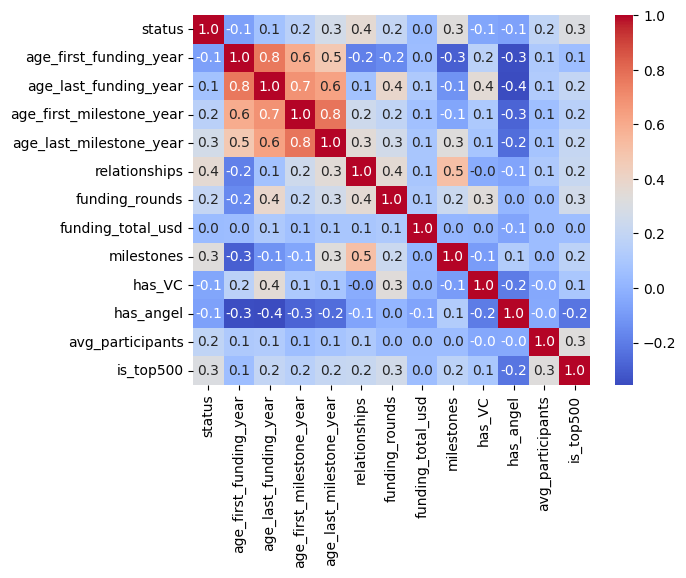

In [28]:
corr_matt = data.corr(numeric_only=True)
sns.heatmap(corr_matt, annot=True, cmap="coolwarm", fmt=".1f")

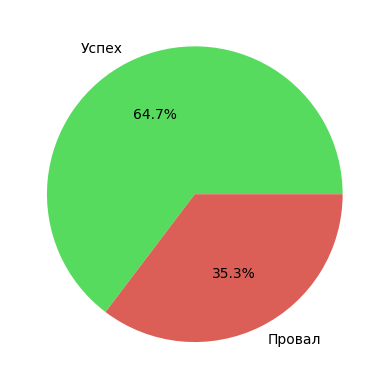

In [29]:
# распределение целевой переменной status
plt.pie(data['status'].value_counts(), labels = ['Успех', 'Провал'],  colors=sns.color_palette('hls')[2::-2], autopct='%.1f%%')
plt.show()

#### Обработка пропущенных значений

In [30]:
data.isnull().sum()

state_code                    0
status                        0
age_first_funding_year        0
age_last_funding_year         0
age_first_milestone_year    152
age_last_milestone_year     152
relationships                 0
funding_rounds                0
funding_total_usd             0
milestones                    0
category_code                 0
has_VC                        0
has_angel                     0
avg_participants              0
is_top500                     0
dtype: int64

In [31]:
data.dropna(axis=1, inplace=True)

In [32]:
data.isnull().sum()


state_code                0
status                    0
age_first_funding_year    0
age_last_funding_year     0
relationships             0
funding_rounds            0
funding_total_usd         0
milestones                0
category_code             0
has_VC                    0
has_angel                 0
avg_participants          0
is_top500                 0
dtype: int64

In [33]:
data = pd.get_dummies(data, columns=['state_code'], drop_first=True)
data.head()

,status,age_first_funding_year,age_last_funding_year,relationships,funding_rounds,funding_total_usd,milestones,category_code,has_VC,has_angel,...,state_code_OR,state_code_PA,state_code_RI,state_code_TN,state_code_TX,state_code_UT,state_code_VA,state_code_WA,state_code_WI,state_code_WV
0,1,2.2493,3.0027,3,3,375000,3,music,0,1,...,False,False,False,False,False,False,False,False,False,False
1,1,5.1260,9.9973,9,4,40100000,1,enterprise,1,0,...,False,False,False,False,False,False,False,False,False,False
2,1,1.0329,1.0329,5,1,2600000,2,web,0,0,...,False,False,False,False,False,False,False,False,False,False
3,1,3.1315,5.3151,5,3,40000000,1,software,0,0,...,False,False,False,False,False,False,False,False,False,False
4,0,0.0000,1.6685,2,2,1300000,1,games_video,1,1,...,False,False,False,False,False,False,False,False,False,False


#### Нормализуем данные

In [34]:
print(data.dtypes)

status                      int64
age_first_funding_year    float64
age_last_funding_year     float64
relationships               int64
funding_rounds              int64
funding_total_usd           int64
milestones                  int64
category_code              object
has_VC                      int64
has_angel                   int64
avg_participants          float64
is_top500                   int64
state_code_AZ                bool
state_code_CA                bool
state_code_CO                bool
state_code_CT                bool
state_code_DC                bool
state_code_FL                bool
state_code_GA                bool
state_code_ID                bool
state_code_IL                bool
state_code_IN                bool
state_code_KY                bool
state_code_MA                bool
state_code_MD                bool
state_code_ME                bool
state_code_MI                bool
state_code_MN                bool
state_code_MO                bool
state_code_NC 